# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.ensemble import BalancedRandomForestClassifier


# 2. Looking the dataset

In [2]:
fraud = pd.read_csv('fraud.csv')
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
fraud.shape

(6362620, 11)

In [4]:
fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
fraud.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
type_percentages = fraud["type"].value_counts(normalize = True)* 100
print(type_percentages)

type
CASH_OUT    35.166331
PAYMENT     33.814608
CASH_IN     21.992261
TRANSFER     8.375622
DEBIT        0.651178
Name: proportion, dtype: float64


In [7]:
fraud_percentages = fraud["isFraud"].value_counts(normalize = True)* 100
print(fraud_percentages)

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


### As expected in a fraud situation, the data is unbalanced, thus we must be careful about the metrics we use to measure our model. Consider a model that predicts non-fraud for every observation, regardless of the attributes. This absolutely useless model has a 99.87% accuracy rate simply because there is 99.87% of 0! In this scenario, utilizing accuracy is completely incorrect.

In [8]:
fraud.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

# 3. Models


In [9]:
X = fraud.drop(columns= ['isFraud', 'nameOrig', 'nameDest'])
y = fraud['isFraud']
print(X.shape)
print(y.shape)

(6362620, 8)
(6362620,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=314)

In [11]:

categorical_features = ['type']
numeric_features = X.columns.difference(categorical_features).tolist()


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=314)


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

# Random Forest
rf_balanced_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=314))
])
rf_balanced_pipeline.fit(X_train, y_train)
y_pred_rf = rf_balanced_pipeline.predict(X_test)
print("Random Forest (class_weight='balanced')")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_rf))

# XGBoost
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=314))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
print("\nXGBoost (scale_pos_weight)")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_xgb))


# Logistic Regression 
lr_balanced_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=314))
])
lr_balanced_pipeline.fit(X_train, y_train)
y_pred_lr = lr_balanced_pipeline.predict(X_test)
print("\nLogistic Regression (class_weight='balanced')")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_lr))

# Balanced Random Forest
brf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BalancedRandomForestClassifier(random_state=314))
])
brf_pipeline.fit(X_train, y_train)
y_pred_brf = brf_pipeline.predict(X_test)
print("\nBalanced Random Forest")
print(classification_report(y_test, y_pred_brf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_brf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_brf))

Random Forest (class_weight='balanced')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.99      0.76      0.86      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.88      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
[[1270865      16]
 [    398    1245]]
ROC-AUC Score: 0.8788738025369774

XGBoost (scale_pos_weight)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.46      0.99      0.63      1643

    accuracy                           1.00   1272524
   macro avg       0.73      0.99      0.81   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
[[1268960    1921]
 [     19    1624]]
ROC-AUC Score: 0.9934621191652319


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression (class_weight='balanced')
              precision    recall  f1-score   support

           0       1.00      0.91      0.95   1270881
           1       0.01      0.89      0.03      1643

    accuracy                           0.91   1272524
   macro avg       0.51      0.90      0.49   1272524
weighted avg       1.00      0.91      0.95   1272524

Confusion Matrix:
[[1159621  111260]
 [    177    1466]]
ROC-AUC Score: 0.9023623342940315


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in th


Balanced Random Forest
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270881
           1       0.09      1.00      0.16      1643

    accuracy                           0.99   1272524
   macro avg       0.54      0.99      0.58   1272524
weighted avg       1.00      0.99      0.99   1272524

Confusion Matrix:
[[1254231   16650]
 [      6    1637]]
ROC-AUC Score: 0.9916234978479277


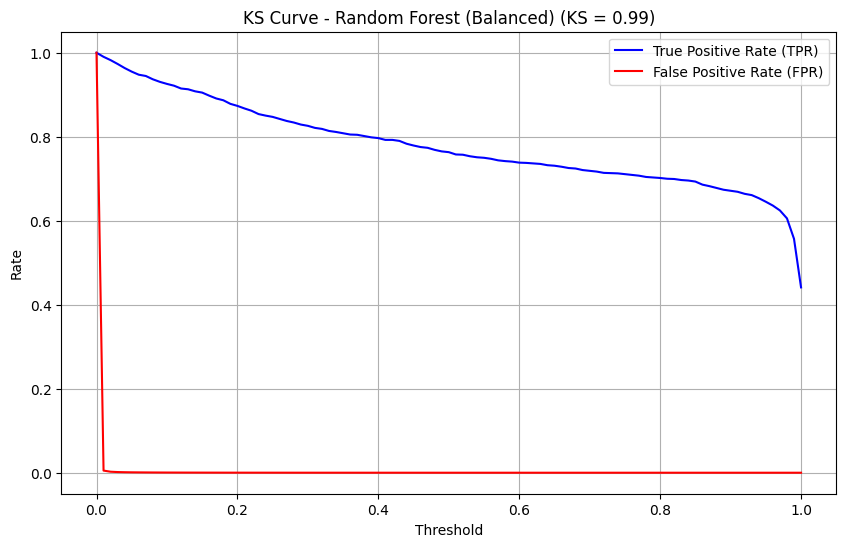

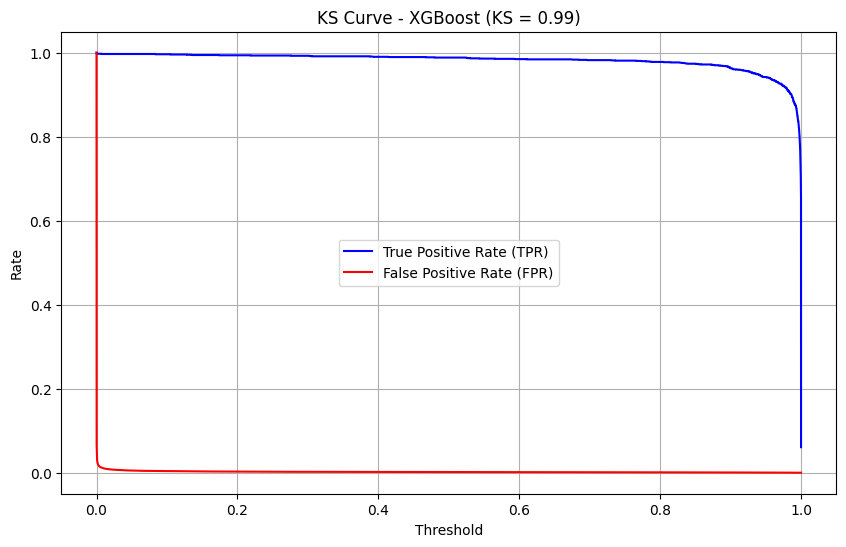

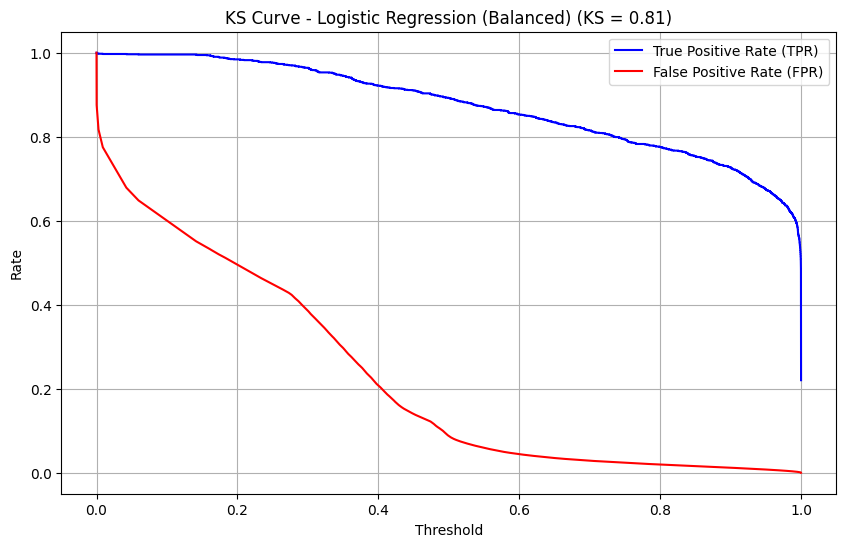

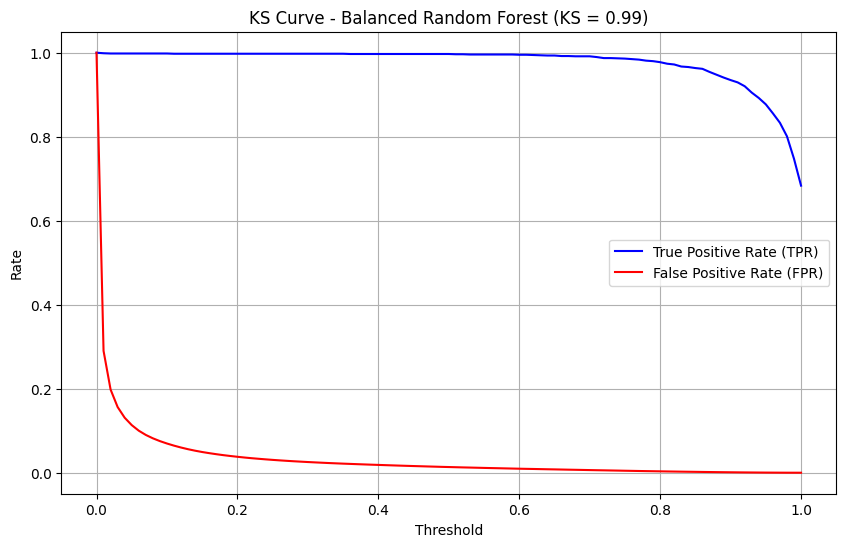

KS Statistic for Random Forest: 0.9851786283414307
KS Statistic for XGBoost: 0.992909987334865
KS Statistic for Logistic Regression: 0.8131799061204293
KS Statistic for Balanced Random Forest: 0.9859018273013703


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from scipy import stats

def plot_ks_curve(y_true, y_scores, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    ks_stat = max(tpr - fpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, tpr, label='True Positive Rate (TPR)', color='b')
    plt.plot(thresholds, fpr, label='False Positive Rate (FPR)', color='r')
    plt.title(f'KS Curve - {model_name} (KS = {ks_stat:.2f})')
    plt.xlabel('Threshold')
    plt.ylabel('Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return ks_stat

# Prevendo as probabilidades de cada modelo para calcular KS
y_prob_rf = rf_balanced_pipeline.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
y_prob_lr = lr_balanced_pipeline.predict_proba(X_test)[:, 1]
y_prob_brf = brf_pipeline.predict_proba(X_test)[:, 1]

# Calculando e plotando as curvas KS
ks_rf = plot_ks_curve(y_test, y_prob_rf, "Random Forest (Balanced)")
ks_xgb = plot_ks_curve(y_test, y_prob_xgb, "XGBoost")
ks_lr = plot_ks_curve(y_test, y_prob_lr, "Logistic Regression (Balanced)")
ks_brf = plot_ks_curve(y_test, y_prob_brf, "Balanced Random Forest")

print(f"KS Statistic for Random Forest: {ks_rf}")
print(f"KS Statistic for XGBoost: {ks_xgb}")
print(f"KS Statistic for Logistic Regression: {ks_lr}")
print(f"KS Statistic for Balanced Random Forest: {ks_brf}")
